In [2]:
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

# Data retrieval and cleaning

In [9]:
df = pd.read_excel('退職予測データ.xlsx','学習データ')

In [4]:
df.head()

,社員ID,退職FLG,部署,役職ランクCD,性別,結婚歴,年齢,雇用形態,勤続年数,勤務先,手当有無,所属子会社名,報酬制度,勤務タイプ,直近1年の残業時間,現ポジションの経過年数
0,1,No,開発,1,男性,結婚,32,3年ごと更新,4.083333,29,あり,ホールディングス,年俸制,客先常駐,82.850,4.083333
1,2,No,開発,1,男性,結婚,41,正社員,2.166667,30,あり,子会社①,年俸制,本社勤務,223.929,0.666667
2,3,No,開発,1,女性,結婚,34,5年ごと更新,4.916667,23,無し,子会社②,年俸制,客先常駐,3.000,4.916667
3,4,No,開発,1,男性,独身,32,3年ごと更新,3.083333,30,無し,子会社①,年俸制,本社勤務,3.250,0.250000
4,5,No,開発,1,男性,結婚,29,1年ごと更新,0.500000,2,あり,子会社①,年俸制,本社勤務,0.000,0.500000


In [6]:
df.dtypes

社員ID             int64
退職FLG           object
部署              object
役職ランクCD         object
性別              object
結婚歴             object
年齢               int64
雇用形態            object
勤続年数           float64
勤務先              int64
手当有無            object
所属子会社名          object
報酬制度            object
勤務タイプ           object
直近1年の残業時間      float64
現ポジションの経過年数    float64
dtype: object

In [10]:
cols_eng = 'employee ID,Retirement FLG,Department,Job rank CD,sex,marital status,age,Employment status,Length of service,workplace,allowance,Affiliated subsidiary name,Compensation system,work type,Overtime hours in the last year,Number of years in current position'.split(',')
cols_eng = [col.replace(" ","_").lower() for col in cols_eng]
cols_jp = [col for col in df.columns]
cols_dict = {}
for idx, col in enumerate(cols_eng):
    cols_dict[col] = cols_jp[idx]
cols_dict
df.columns = cols_eng
df.head()


,employee_id,retirement_flg,department,job_rank_cd,sex,marital_status,age,employment_status,length_of_service,workplace,allowance,affiliated_subsidiary_name,compensation_system,work_type,overtime_hours_in_the_last_year,number_of_years_in_current_position
0,1,No,開発,1,男性,結婚,32,3年ごと更新,4.083333,29,あり,ホールディングス,年俸制,客先常駐,82.850,4.083333
1,2,No,開発,1,男性,結婚,41,正社員,2.166667,30,あり,子会社①,年俸制,本社勤務,223.929,0.666667
2,3,No,開発,1,女性,結婚,34,5年ごと更新,4.916667,23,無し,子会社②,年俸制,客先常駐,3.000,4.916667
3,4,No,開発,1,男性,独身,32,3年ごと更新,3.083333,30,無し,子会社①,年俸制,本社勤務,3.250,0.250000
4,5,No,開発,1,男性,結婚,29,1年ごと更新,0.500000,2,あり,子会社①,年俸制,本社勤務,0.000,0.500000


In [11]:
cols_to_drop = ['employee_id']
df = df[[col for col in df.columns if col not in cols_to_drop]].copy()
df.head()

df.job_rank_cd = df.job_rank_cd.apply(lambda x: 5 if type(x)==str else x)

df_copy = df.copy()

df.job_rank_cd.value_counts()

1    1520
2     114
3      50
5      10
4       1
Name: job_rank_cd, dtype: int64

In [12]:
df.retirement_flg = df.retirement_flg.apply(lambda x: 1 if x=='Yes' else 0)
df.allowance = df.allowance.apply(lambda x: 1 if x=='あり' else 0)
df.head()

,retirement_flg,department,job_rank_cd,sex,marital_status,age,employment_status,length_of_service,workplace,allowance,affiliated_subsidiary_name,compensation_system,work_type,overtime_hours_in_the_last_year,number_of_years_in_current_position
0,0,開発,1,男性,結婚,32,3年ごと更新,4.083333,29,1,ホールディングス,年俸制,客先常駐,82.850,4.083333
1,0,開発,1,男性,結婚,41,正社員,2.166667,30,1,子会社①,年俸制,本社勤務,223.929,0.666667
2,0,開発,1,女性,結婚,34,5年ごと更新,4.916667,23,0,子会社②,年俸制,客先常駐,3.000,4.916667
3,0,開発,1,男性,独身,32,3年ごと更新,3.083333,30,0,子会社①,年俸制,本社勤務,3.250,0.250000
4,0,開発,1,男性,結婚,29,1年ごと更新,0.500000,2,1,子会社①,年俸制,本社勤務,0.000,0.500000


# EDA

## Potential Questions:  
1. How many years until a certain employee retire?
2. What is the probability that a certain employee will retire in X year?
3. What are the contributing factors to retirement?

In [13]:
df.department.value_counts()

開発         1504
営業          106
バックオフィス      85
Name: department, dtype: int64

In [14]:
def bar_chart(col_name, bar_w=2, graph_h=7):
    count = df[col_name].value_counts()
    x_labels = [val for val in count.index]
    fig, ax = plt.subplots(figsize=(len(x_labels)*bar_w, graph_h))
    ax.bar(count.index, count.values)
    ax.set_xticklabels(x_labels, fontname='MS Gothic')
    plt.show()

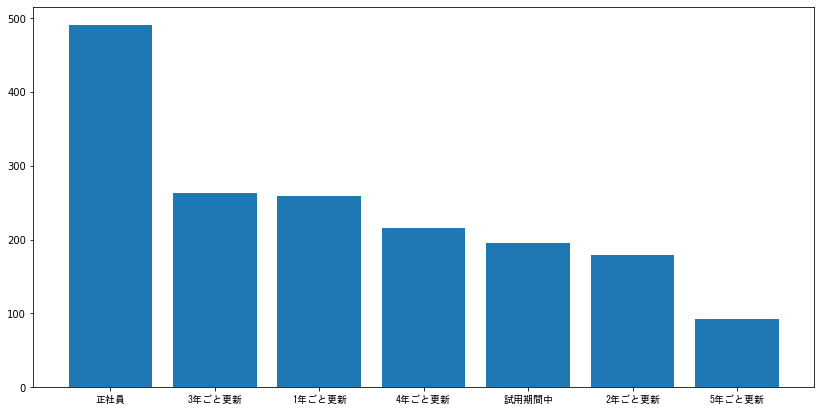

In [15]:
bar_chart('employment_status',2,7)

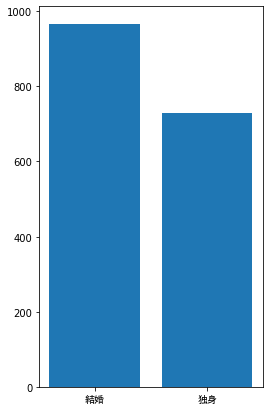

In [16]:
bar_chart('marital_status')

In [17]:
TARGET = 'retirement_flg'
num_cols = [col for col in df.columns if df[col].dtype != object and col != TARGET]
cat_cols = [col for col in df.columns if col not in num_cols and col != TARGET]

cat_cols

['department',
 'sex',
 'marital_status',
 'employment_status',
 'affiliated_subsidiary_name',
 'compensation_system',
 'work_type']

In [18]:
df[df.retirement_flg==0].department.unique()

array(['開発', 'バックオフィス', '営業'], dtype=object)

In [19]:
a = df.employment_status.value_counts()
'正社員' in a.index

True

In [20]:
def multi_bar_chart(col, bar_w=0.35, graph_h=7, type='grouped', val_type='count'):
    labels = df[col].unique()
    retired_temp = df[df.retirement_flg==1][col].value_counts()
    not_retired_temp = df[df.retirement_flg==0][col].value_counts()

    if val_type == 'percent':
        count_all=df[col].value_counts()
        retired = [0 if label not in retired_temp.index else retired_temp[label] / count_all[label] for label in labels]
        not_retired = [0 if label not in not_retired_temp.index else not_retired_temp[label] / count_all[label] for label in labels]
    else:
        retired = [0 if label not in retired_temp.index else retired_temp[label]  for label in labels]
        not_retired = [0 if label not in not_retired_temp.index else not_retired_temp[label] for label in labels]


    x = np.arange(len(labels))  # the label locations
    width = bar_w  # the width of the bars

    fig, ax = plt.subplots(figsize=(len(labels)*1.5, graph_h))
    if type=='grouped':
        rects1 = ax.bar(x - width/2, retired, width, label='Retired')
        rects2 = ax.bar(x + width/2, not_retired, width, label='Not Retired')
    if type=='stacked':
        rects1 = ax.bar(x, retired, width, label='Retired')
        rects2 = ax.bar(x, not_retired, width, bottom=retired, label='Not Retired')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Count')
    ax.set_title(f'Count retired and not-retired by {col}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontname='MS Gothic')
    ax.legend()

    fig.tight_layout()

    plt.show()

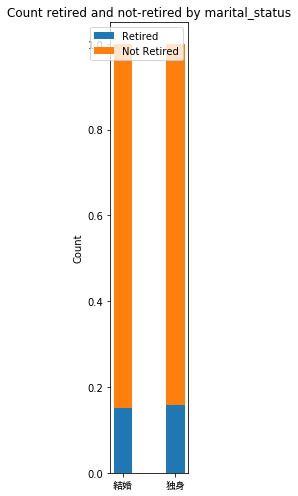

In [23]:
multi_bar_chart('marital_status',0.35, 7, "stacked", "percent")

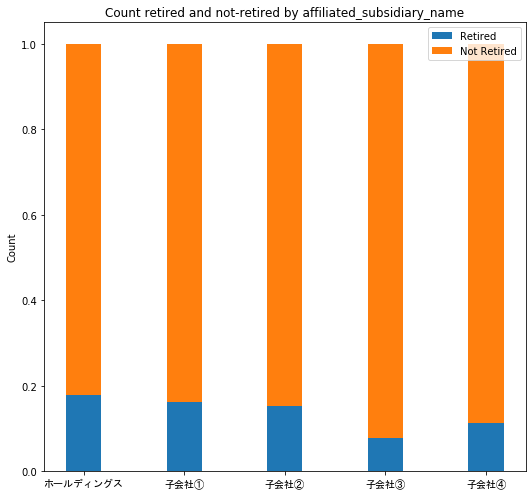

In [24]:
multi_bar_chart('affiliated_subsidiary_name', 0.35, 7, 'stacked', 'percent')

In [25]:
print('Median')
print(df.groupby('retirement_flg')['number_of_years_in_current_position'].median())
print('Mean')
print(df.groupby('retirement_flg')['number_of_years_in_current_position'].mean())

Median
retirement_flg
0    1.458333
1    1.250000
Name: number_of_years_in_current_position, dtype: float64
Mean
retirement_flg
0    2.591527
1    2.793103
Name: number_of_years_in_current_position, dtype: float64


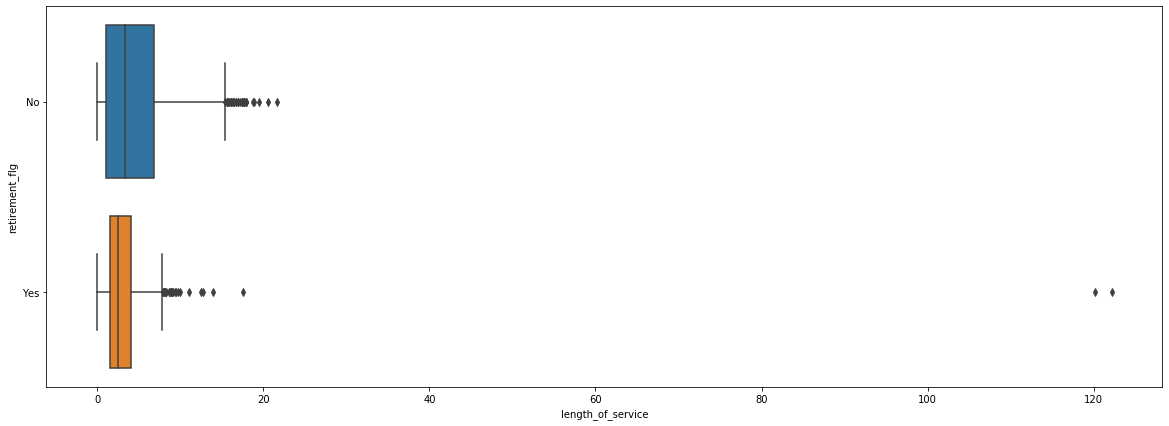

In [26]:
fig, ax = plt.subplots(figsize=(20,7))
sns.boxplot(data=df_copy, x="length_of_service", y="retirement_flg", ax=ax)

In [19]:
df.describe()

,retirement_flg,age,length_of_service,workplace,allowance,overtime_hours_in_the_last_year,number_of_years_in_current_position
count,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000
mean,0.153982,33.568732,4.375764,24.979351,0.384661,110.784232,2.622566
std,0.361038,6.900616,5.600409,9.347303,0.486659,129.318345,5.135841
min,0.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,29.000000,1.166667,26.000000,0.000000,0.000000,0.583333
50%,0.000000,32.000000,3.166667,29.000000,0.000000,64.912000,1.416667
75%,0.000000,37.000000,6.416667,30.000000,1.000000,174.000000,3.000000
max,1.000000,64.000000,122.166667,39.000000,1.000000,629.150000,122.166667


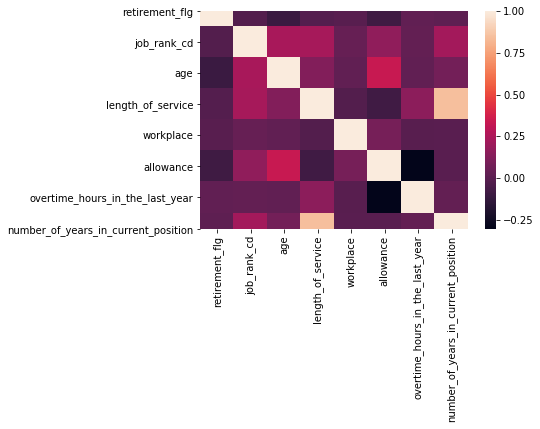

In [27]:
sns.heatmap(df.corr())

In [21]:
#TODO:
# Create new feature: years from contract renewal based on employment status and year in current position
# Create past version of people as new data points

# Modelling

In [62]:
# #One hot encoding
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import make_column_transformer

# transformer = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), cat_cols))
# transformed = transformer.fit_transform(df)
# # transformed.toarray().shape
# # len(transformer.get_feature_names())
# cat_encoded = pd.DataFrame(transformed.toarray(), columns=transformer.get_feature_names())
# df_encoded = pd.concat([df[num_cols], cat_encoded], axis=1)

# df_encoded.head()

In [63]:
#Testing a model
df_encoded = pd.get_dummies(df)

TARGET = 'retirement_flg'
FEATURES = [col for col in df_encoded.columns if col != TARGET]

# splitting X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_encoded[FEATURES], df_encoded[TARGET], test_size=0.3, random_state=1)
  
# training the model on training set
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
  
# making predictions on the testing set
y_pred = gnb.predict(X_test)
  
# comparing actual response values (y_test) with predicted response values (y_pred)
from sklearn import metrics
print("Gaussian Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)

Gaussian Naive Bayes model accuracy(in %): 74.65618860510806
